In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
from tensorflow.keras import backend as K

## Data Preprocessing

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]


Text(0.5, 1.0, 'Very unbalanced Class')

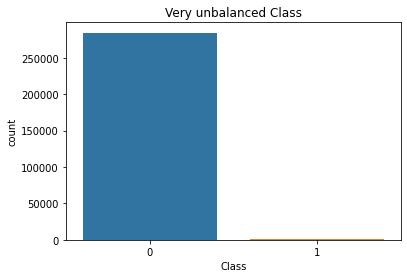

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditCardFraudDetection/creditcard.csv")
print(df.head())
sns.countplot(x=df.Class).set_title('Very unbalanced Class')

Use RobustScaler which is less prone to outliers to normalized Amount and remove Time because its not clear why we need that.

In [4]:
df['Scaled_Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1,  inplace = True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579


Strafied train, test, val split so that there are equal numbers of fraud 
cases in each splits.

In [5]:
X = df.drop("Class",axis = 1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.1, 
                                                  stratify = y_train)

print("X:", X.shape, y.shape )
print("Train:", X_train.shape, y_train.shape )
print("Test:", X_test.shape, y_test.shape )
print("Val:", X_val.shape, y_val.shape )

print("{:0.3f} % of fraud case in dataframe.".format(((y==1).astype(int).sum())/((y==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Train split.".format(((y_train==1).astype(int).sum())/((y_train==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Val split.".format(((y_val==1).astype(int).sum())/((y_val==0).astype(int).sum())*100) )
print("{:0.3f} % of fraud case in Test split.".format(((y_test==1).astype(int).sum())/((y_test==0).astype(int).sum())*100) )

X: (284807, 29) (284807,)
Train: (230693, 29) (230693,)
Test: (28481, 29) (28481,)
Val: (25633, 29) (25633,)
0.173 % of fraud case in dataframe.
0.173 % of fraud case in Train split.
0.172 % of fraud case in Val split.
0.172 % of fraud case in Test split.


In [6]:
def focal_loss(alpha, gamma):
  """Focal Loss Functiion: FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
  Put more emphasis on fraudulent cases incompare to nonfraudulent cases during
  training."""
  def calc_focal_loss(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true , tf.float32 )

    p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
    loss = (alpha*y_true+(1.0-alpha)*(1.0-y_true))*tf.pow((1.0-p_t),gamma)*-K.log(p_t+K.epsilon())
    return tf.reduce_sum(loss)
  return calc_focal_loss

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(512, 
                        input_shape=(29,),
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.leaky_relu),

  tf.keras.layers.Dense(256, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.leaky_relu),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(64, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.leaky_relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.zeros(), 
                        activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(1, 
                        kernel_initializer=tf.keras.initializers.HeNormal(), 
                        bias_initializer=tf.keras.initializers.Constant(1),
                        activation=tf.nn.sigmoid)])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = focal_loss(alpha=0.25, gamma=3.0),
              metrics=[tf.keras.metrics.AUC(curve="PR"),#Precision-Recall-Curve
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto',
                                              patience=20, min_delta=0.0001,
                                               restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                  patience=20,min_delta=0.00001,
                                                  verbose=1,mode='auto')]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15360     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

In [8]:
"""Note that batch_size is unusualy high becasue we want to make sure  in each
batch there are some Fradulant cases to learn."""

train_history = model.fit(X_train, y_train, batch_size=1024, epochs=500,
                          shuffle= True, validation_data=(X_val,y_val),
                          callbacks=callbacks)

Epoch 1/500
226/226 [==============================] - 4s 9ms/step - loss: 100.2849 - auc: 0.0014 - precision: 2.7537e-04 - recall: 0.0276 - val_loss: 6.4243 - val_auc: 0.0010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
226/226 [==============================] - 1s 5ms/step - loss: 6.7516 - auc: 0.0021 - precision: 0.0013 - recall: 0.0010 - val_loss: 3.5170 - val_auc: 0.0013 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
226/226 [==============================] - 1s 5ms/step - loss: 3.9054 - auc: 0.1237 - precision: 0.1619 - recall: 0.1469 - val_loss: 1.3566 - val_auc: 0.6315 - val_precision: 0.8611 - val_recall: 0.7045
Epoch 4/500
226/226 [==============================] - 1s 5ms/step - loss: 2.3946 - auc: 0.3467 - precision: 0.5129 - recall: 0.4111 - val_loss: 1.3268 - val_auc: 0.6722 - val_precision: 0.8718 - val_recall: 0.7727
Epoch 5/500
226/226 [==============================] - 1s 5ms/step - loss: 2.0889 - auc: 0.4883 - precision: 0.6635 - 

In [9]:
def plot_train_history(train_history):
  fig, axs = plt.subplots(1,2, figsize=(20,8))
  axs[0].plot(train_history.history['loss'])
  axs[0].plot(train_history.history['val_loss'])
  axs[0].set_title("Model Training and Testing loss:")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("loss")
  axs[0].legend(['Train', "Val"])
  
  axs[1].plot(train_history.history['auc'])
  axs[1].plot(train_history.history['val_auc'])
  axs[1].set_title("AUC-Precision-Recall-curve Training and Testing:")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("AUC-PR")
  axs[1].legend(['Train', "Val"])

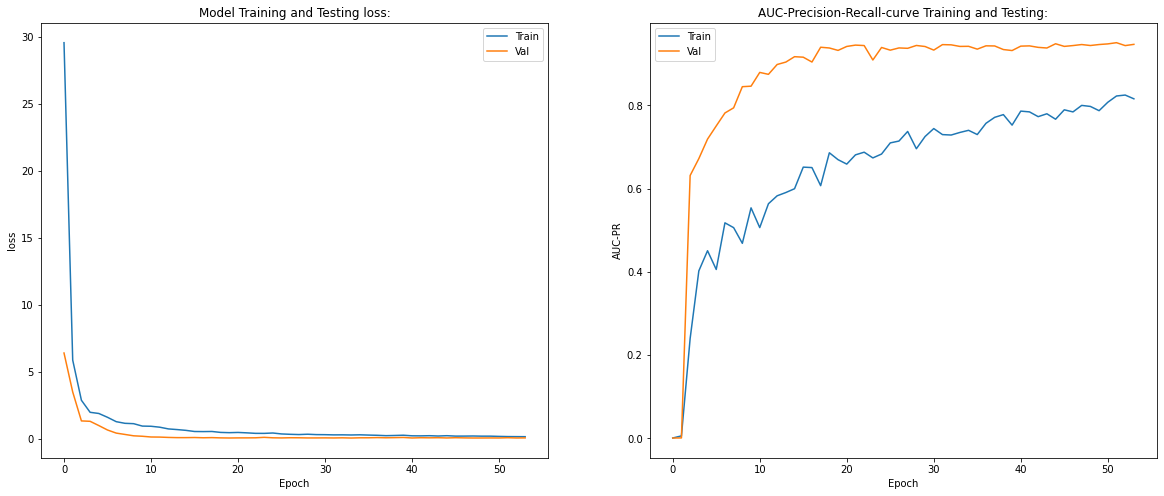

In [10]:
plot_train_history(train_history)

In [11]:
test_loss, test_auc, test_pre, test_recall = model.evaluate(X_test, y_test)
print("Test AUC-PR score: ", test_auc)
print("Test Precission: ", test_pre)
print("Test Recall: ", test_recall)
print("Test F1 score: ", 2*((test_pre*test_recall)/(test_pre+test_recall)) )

891/891 [==============================] - 3s 3ms/step - loss: 0.0068 - auc: 0.8084 - precision: 0.8478 - recall: 0.7959
Test AUC-PR score:  0.8083727359771729
Test Precission:  0.8478260636329651
Test Recall:  0.795918345451355
Test F1 score:  0.8210526089919241


Text(0.5, 0.98, 'Confusion Matrix of Test data')

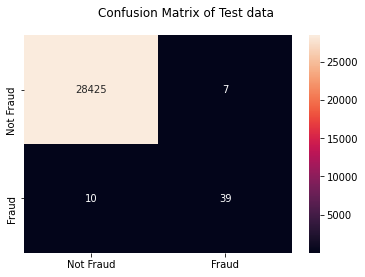

In [12]:
y_pred_test = model.predict(X_test) >= 0.5

cMatrix = confusion_matrix(y_true=y_test,y_pred=y_pred_test)
classes = ("Not Fraud", "Fraud")
ax = sns.heatmap(cMatrix,annot=True,fmt="d",xticklabels=classes,
                 yticklabels=classes)
plt.suptitle('Confusion Matrix of Test data')

In [13]:
model.save('credit_card_fraud_detect.h5')